<a href="https://colab.research.google.com/github/alfinmaulani/skripsi/blob/master/combined(glove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
url0='https://raw.githubusercontent.com/alfinmaulani/skripsi/master/dataISEAR.csv'
df = pd.read_csv(url0)

In [75]:
df=df.drop(df[df['emosi'] == 'shame'].sample(frac=1).index)
df=df.drop(df[df['emosi'] == 'guilt'].sample(frac=1).index)

In [18]:
df.emosi.value_counts()

joy        1092
sadness    1082
anger      1079
fear       1076
disgust    1066
Name: emosi, dtype: int64

In [76]:
df2 = pd.read_csv(url0)

In [77]:
df2=df2.drop(df2[df2['emosi'] == 'joy'].sample(frac=1).index)
df2=df2.drop(df2[df2['emosi'] == 'sadness'].sample(frac=1).index)
df2=df2.drop(df2[df2['emosi'] == 'anger'].sample(frac=1).index)
df2=df2.drop(df2[df2['emosi'] == 'fear'].sample(frac=1).index)
df2=df2.drop(df2[df2['emosi'] == 'disgust'].sample(frac=1).index)

In [21]:
df2.emosi.value_counts()

shame    1071
guilt    1050
Name: emosi, dtype: int64

In [79]:
df3=pd.read_csv('https://raw.githubusercontent.com/alfinmaulani/skripsi/master/korpus2.txt', delimiter = ";")
df3.columns=['dok','tes']

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df2 = pd.read_csv('/content/drive/MyDrive/twitter_prosessed.csv')

In [6]:
# df3 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower.txt', delimiter = "\t")
# df3.columns = ["arti"]

In [2]:
# df4 = pd.read_csv('/content/drive/MyDrive/idwiki_new_lower2.txt', delimiter = "\t")
# df4.columns = ["arti"]

persiapan corpus tambahan

In [22]:
dfg = pd.DataFrame(df2.dokumen)
dfg.columns=["dok"]

In [ ]:
dfg = pd.DataFrame(df3.arti)
dfg.columns=["dok"]

In [81]:
dfg = pd.DataFrame(df2.dokumen.append(df3.dok,ignore_index=True))
dfg.columns=["dok"]

In [8]:
dfg = pd.DataFrame(df4.arti.append(df3.arti,ignore_index=True))
dfg.columns=["dok"]

In [82]:
dfg

,dok
0,When I realized that I was directing the feeli...
1,I feel guilty when when I realize that I consi...
2,"When I was tired and unmotivated, I shouted at..."
3,When I think that I do not study enough. Afte...
4,"When one has been unjust, stupid towards someo..."
...,...
22115,i just had a very brief time in the beanbag an...
22116,i am now turning and i feel pathetic that i am...
22117,i feel strong and good overall
22118,i feel like this was such a rude comment and i...


preputama : lower case

In [83]:
def lower(temp):
  return temp.str.lower()

In [84]:
df['dokumen']=lower(df['dokumen'])

In [85]:
dfg['dok']=lower(dfg['dok'])

preputama : Pembersihan noise (over enter and space)

In [86]:
def bersih_noise(temp):
  temp=temp.replace(' \n', ' ', regex=True)
  temp=temp.replace('   ', ' ', regex=True)
  return temp.replace('  ', ' ', regex=True)

In [87]:
df=bersih_noise(df)

In [88]:
dfg=bersih_noise(dfg)

preptambah : expand contractions

In [89]:
!pip install contractions
import contractions
def expand_word(temp):
  expanded_words = []   
  for word in temp:
    expanded_words.append(contractions.fix(word))
  return expanded_words

     |████████████████████████████████| 321 kB 5.8 MB/s 
     |████████████████████████████████| 284 kB 42.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=149189c783591d2d32be437a88a34ec73d08e611c3d61d2ef69516132537b424
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [90]:
df.dokumen=expand_word(df.dokumen)

In [91]:
dfg.dok=expand_word(dfg.dok)

preputama : cleansing punctuation

In [92]:
def clns_punc(temp):
  return temp.str.replace(r'[^\w\s]+', '')

In [93]:
df['dokumen'] = clns_punc(df['dokumen'])

In [94]:
dfg['dok'] = clns_punc(dfg['dok'])

preputama : cleansing number

In [95]:
!pip install tweet-preprocessor
import preprocessor as p
p.set_options(p.OPT.NUMBER)
def clns_numb(temp):
  sementara=[]
  for word in temp:
    sementara.append(p.clean(word))
  return sementara

In [96]:
df.dokumen=clns_numb(df.dokumen)

In [97]:
dfg.dok=clns_numb(dfg.dok)

preptambah : remove stopword

In [98]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
pat = r'\b(?:{})\b'.format('|'.join(stop))
def remove_stopw(temp):
  temp=temp.str.replace(pat, '')
  return temp.str.replace(r'\s+', ' ')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [99]:
df['dokumen'] = remove_stopw(df['dokumen'])

In [100]:
dfg['dok'] = remove_stopw(dfg['dok'])

tokenizing

In [101]:
def token(temp):
  return [word_tokenize(x) for x in temp]

In [102]:
df.dokumen=token(df.dokumen)

In [103]:
dfg.dok=token(dfg.dok)

preptambah : Lemmatization

In [104]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def lemma(temp):
  temp.apply(lambda x: [stemmer.stem(y) for y in x])

In [105]:
lemma(df['dokumen'])

In [106]:
lemma(dfg['dok'])

save df

In [ ]:
# df.to_csv(r'dataisear(preptambah).csv', index = False)

gabung corpus

In [ ]:
# sent=df.dokumen

In [107]:
sent=dfg.dok.append(df.dokumen,ignore_index=True)

glove

In [31]:
!pip install glove-python-binary

In [32]:
from glove import Glove
from glove import Corpus

In [108]:
korpus = Corpus()
korpus.fit(sent, window=5, ignore_missing=True)

In [ ]:
# (corpus, window=10, ignore_missing=False)

In [109]:
glove = Glove(no_components=100, learning_rate=0.1, alpha=0.025, max_count=100, max_loss=10.0, random_state=None)
glove.fit(korpus.matrix)
glove.add_dictionary(korpus.dictionary)

In [ ]:
# (no_components=30, learning_rate=0.05, alpha=0.75, max_count=100, max_loss=10.0, random_state=None)

cek model

In [110]:
glove.word_vectors.shape

(20277, 100)

In [111]:
glove.word_vectors[glove.dictionary['moment']]

array([ 0.4144601 , -0.13807383,  0.1170888 , -0.18473299,  0.19097473,
       -0.16017822,  0.17560281,  0.07849689,  0.03141588,  0.07624825,
        0.42733769,  0.13772954,  0.01267495, -0.03084319,  0.10301294,
        0.12559499, -0.30137573,  0.32226572, -0.37489593, -0.00133802,
        0.04309611, -0.10034052,  0.10894226, -0.15050735, -0.15233888,
        0.10675149, -0.0281836 , -0.24147253,  0.10224558,  0.17806076,
        0.01184032, -0.06320943, -0.15236491, -0.41997841, -0.16283667,
        0.3473194 , -0.32799954,  0.07841665,  0.45426697, -0.10439129,
        0.39672753, -0.22330418, -0.24757202, -0.22970845, -0.04415052,
        0.03751966, -0.20057184,  0.15765327, -0.18882439,  0.22485062,
       -0.09900324, -0.41442299,  0.08719782,  0.54876748,  0.04953454,
        0.47334933,  0.0305849 , -0.09204967, -0.1421105 ,  0.44371599,
        0.1335801 ,  0.11829002, -0.06427672,  0.13583263, -0.06073612,
        0.36356743, -0.03286868, -0.30439954,  0.00900617, -0.35

ekstraksi fitur

In [112]:
import array
ekstrak=[]
temp=array.array('i',(0,)*100)
for senten in df.dokumen:
  for word in senten:
    temp=np.add(temp,glove.word_vectors[glove.dictionary[word]])
  temp=temp/len(senten)
  ekstrak.append(temp)
has_vec=ekstrak

In [113]:
X=has_vec
y=df.emosi
print(np.shape(X))
print(np.shape(y))
# print(X)
# print(y)

(5395, 100)
(5395,)


klasifikasi svm

In [114]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
# langsung cari score

# clf = svm.SVC(kernel='poly', decision_function_shape='ovr')
# scores = cross_val_score(clf, X, y, cv=10)
# # scores.mean()

conf matrix dan akurasi

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
#  class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

In [ ]:
# cross_val_predict(estimator, X, y=None, *, groups=None, cv=None, n_jobs=None, verbose=0, fit_params=None, 
# pre_dispatch='2*n_jobs', method='predict')

In [115]:
def klasifikasi(krnl):
  clf = svm.SVC(kernel=krnl, decision_function_shape='ovr')
  y_pred = cross_val_predict(clf, X, y, cv=10)
  ConfusionMatrixDisplay.from_predictions(y, y_pred)
  plt.show()
  print(accuracy_score(y, y_pred))
  print(precision_recall_fscore_support(y, y_pred, average='macro'))

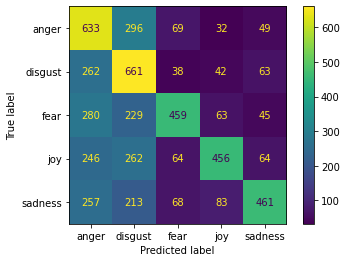

0.494902687673772
(0.5566580518160518, 0.49539090925271456, 0.49999281261523476, None)


In [116]:
klasifikasi('poly')

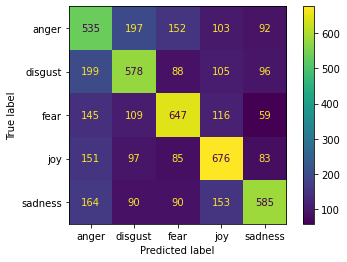

0.5599629286376274
(0.5645249986558837, 0.5598115048160832, 0.5610066583082896, None)


In [117]:
klasifikasi('rbf')

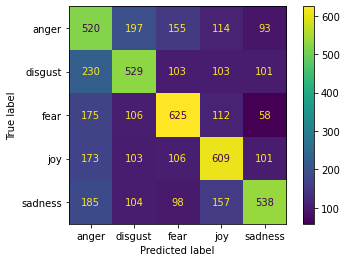

0.5228915662650603
(0.5298801613390867, 0.5227900097308094, 0.5246216812647211, None)


In [118]:
klasifikasi('linear')